# Chatbot with Memory
Memory is a cognitive function that allows people to store, retrieve, and use information to understand their present and future.

### Goals
We'll build a chatbot that uses both short-term (within-thread) and long-term (across-thread) memory.

We'll focus on long-term semantic memory, which will be facts about the user.

These long-term memories will be used to create a personalized chatbot that can remember facts about the user.

### Introduction to the LangGraph Store
The LangGraph Memory Store provides a way to store and retrieve information across threads in LangGraph.

In [1]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects (e.g., memories) in the Store, we provide:

The namespace for the object, a tuple (similar to directories)  
the object key (similar to filenames)  
the object value (similar to file contents)  
We use the put method to save an object to the store by namespace and key.

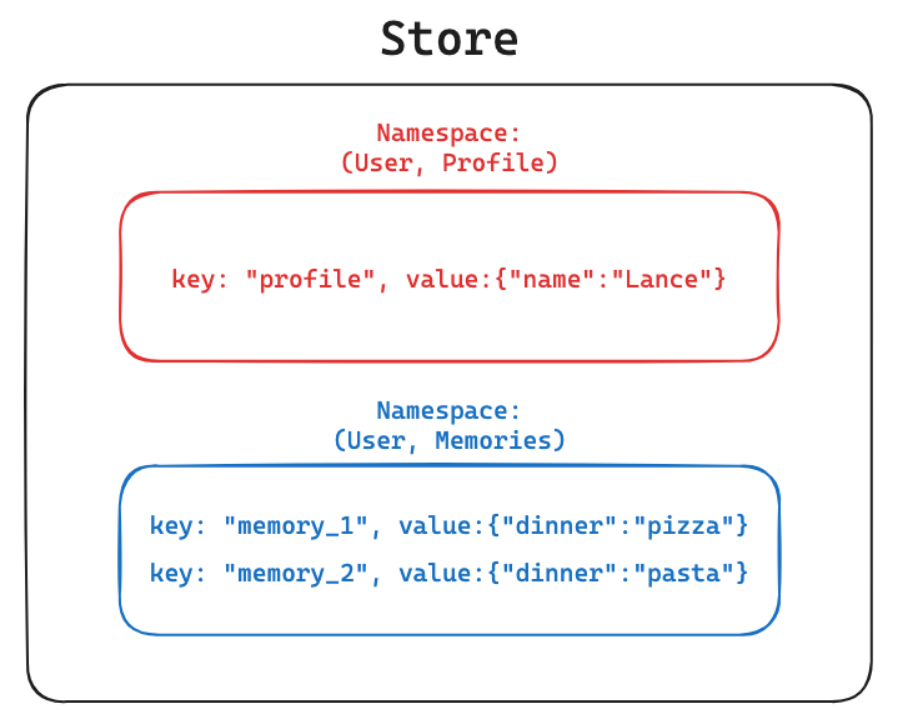

In [2]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

In [3]:
# Search 
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [4]:
# Metatdata 
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '200c60ed-a325-404d-a5af-54cde429f9e6',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-08-12T22:15:58.020285+00:00',
 'updated_at': '2025-08-12T22:15:58.020288+00:00',
 'score': None}

In [5]:
# The key, value
print(memories[0].key, memories[0].value)

200c60ed-a325-404d-a5af-54cde429f9e6 {'food_preference': 'I like pizza'}


In [6]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '200c60ed-a325-404d-a5af-54cde429f9e6',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-08-12T22:15:58.020285+00:00',
 'updated_at': '2025-08-12T22:15:58.020288+00:00'}

### Chatbot with long-term memory
We want a chatbot that has two types of memory:  

Short-term (within-thread) memory: Chatbot can persist conversational history and / or allow interruptions in a chat session.  
Long-term (cross-thread) memory: Chatbot can remember information about a specific user across all chat sessions.

For short-term memory, we'll use a checkpointer.  


They write the graph state at each step to a thread.  
They persist the chat history in the thread.  
They allow the graph to be interrupted and / or resumed from any step in the thread.  
And, for long-term memory, we'll use the LangGraph Store as introduced above.

In [8]:
from langchain.chat_models import init_chat_model
model = init_chat_model(
    "anthropic.claude-3-5-sonnet-20241022-v2:0",
    model_provider="bedrock_converse",
)

The chat history will be saved to short-term memory using the checkpointer.  

The chatbot will reflect on the chat history.  

It will then create and save a memory to the LangGraph Store.  

This memory is accessible in future chat sessions to personalize the chatbot's responses.

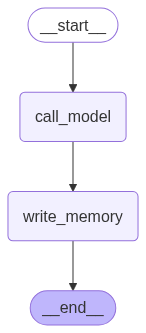

In [9]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

When we interact with the chatbot, we supply two things:

Short-term (within-thread) memory: A thread ID for persisting the chat history.  
Long-term (cross-thread) memory: A user ID to namespace long-term memories to the user.

In [10]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello Lance! Nice to meet you. I don't have any previous memory about you, so I'd love to learn more. Is there anything in particular you'd like to share about yourself or discuss? I'll remember what you tell me to help personalize our future interactions.


In [11]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

Nice to meet you Lance! I'll remember that you enjoy biking in San Francisco. That's a great city for cycling, though those hills can be quite challenging! Do you have any favorite routes or areas you particularly enjoy biking in SF? The Embarcadero, Golden Gate Park, and the Golden Gate Bridge are some popular spots for cyclists. I'd be happy to discuss biking in SF or learn more about your other interests!


We're using the MemorySaver checkpointer for within-thread memory.

This saves the chat history to the thread.

We can look at the chat history saved to the thread.

In [12]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello Lance! Nice to meet you. I don't have any previous memory about you, so I'd love to learn more. Is there anything in particular you'd like to share about yourself or discuss? I'll remember what you tell me to help personalize our future interactions.
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

Nice to meet you Lance! I'll remember that you enjoy biking in San Francisco. That's a great city for cycling, though those hills can be quite challenging! Do you have any favorite routes or areas you particularly enjoy biking in SF? The Embarcadero, Golden Gate Park, and the Golden Gate Bridge are some popular spots for cyclists. I'd be happy to discuss b

Recall that we compiled the graph with our the store:

across_thread_memory = InMemoryStore()
And, we added a node to the graph (write_memory) that reflects on the chat history and saves a memory to the store.

We can to see if the memory was saved to the store.

In [13]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': "\n\nBased on our interaction, I'll update your information:\n\nUSER INFORMATION:\n• Name: Lance\n• Location: San Francisco\n• Interests/Hobbies: \n  - Cycling/biking\n• Current city: San Francisco"},
 'created_at': '2025-08-12T22:17:18.285199+00:00',
 'updated_at': '2025-08-12T22:17:18.285202+00:00'}

Now, let's kick off a new thread with the same user ID.

My Note: Unfortunately it does not show the long memory with an unkown reason


In [14]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi Lance! Since I know you're in San Francisco and enjoy cycling, I have several great recommendations for biking in your area:

1. Golden Gate Bridge to Sausalito - A classic SF ride with stunning views. You can even take the ferry back!

2. The Presidio - Offers beautiful trails through forests and coastal areas with views of the Golden Gate Bridge.

3. Angel Island - Take your bike on the ferry and enjoy car-free roads around the entire island with panoramic bay views.

4. Mount Tamalpais - If you're up for a challenge, riding across the Golden Gate and up Mount Tam is a favorite among local cyclists.

5. The Embarcadero - A flatter, more casual ride along the waterfront from the Ferry Building to Fisherman's Wharf.

6. Golden Gate Park - Miles of bike-friendly paths through

In [15]:
# User input 
input_messages = [HumanMessage(content="Great, are there any bakeries nearby that I can check out? I like a croissant after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great, are there any bakeries nearby that I can check out? I like a croissant after biking.
================================== Ai Message ==================================

I apologize for my previous response where I assumed you were in San Francisco - I actually don't have any information about where you're located! Could you let me know which city or area you're in? Once you share that, I can recommend some great bakeries near your biking routes. 

In general, a fresh croissant is indeed a perfect post-ride treat! The combination of biking and bakeries is a classic pairing that many cyclists enjoy.
